In [3]:
import qutip     as qt
import numpy     as np
import cvxpy     as cp
import itertools as it
import scipy     as sci
import numpy.matlib
import scipy.io
ide    = qt.identity(2)
sx     = qt.sigmax()
sy     = qt.sigmay()
sz     = qt.sigmaz()
si     = qt.identity(2)
v1, d1 = qt.Qobj.eigenstates(sx)
v2, d2 = qt.Qobj.eigenstates(sy)
v3, d3 = qt.Qobj.eigenstates(sz)
zo     = qt.Qobj([[1],[0]])
on     = qt.Qobj([[0],[1]])

numpy.set_printoptions(threshold=10000000)

def new(n,a):
    combin = [on]*n
    state = a*(qt.tensor([zo]*n))
    for i in range(n):
        temp = combin[:]
        temp[i] = zo
        temp = qt.tensor(temp)
        state += temp
    return state.unit()


def GHZ_3D(n): #returns the superposition of the tensor product of eigenvectors of all pauli matricies
    state = qt.tensor([d1[0]]*n) + qt.tensor([d1[1]]*n) +qt.tensor([d2[0]]*n) + qt.tensor([d2[1]]*n) +qt.tensor([d3[0]]*n) + qt.tensor([d3[1]]*n)
    return state.unit()

def ham(alpha, n): # Returns the hamiltonian generator of the external single body magnetic field
    H  = (alpha[0]*SC_estim_ham(sx,n)+alpha[1]*SC_estim_ham(sy,n)+alpha[2]*SC_estim_ham(sz,n))
    return H


def SC_estim_ham(pauli):#sets up estimation hamiltonian for a given pauli (or particular mag field direction)
    N = 2
    h = qt.tensor([qt.Qobj(np.zeros((2,2)))]*N)
    for i in range(0,N):
        a    = [si]*N
        a[i] = pauli
        b    = qt.tensor(a)
        h    += b
    return h


def U_mag(alpha, rho, n): # this states a state and returns that state after experiancing an external magnetic field
    H      = qt.Qobj.expm(-1j*(alpha[0]*SC_estim_ham(sx,n)+alpha[1]*SC_estim_ham(sy,n)+alpha[2]*SC_estim_ham(sz,n)))
    output = H*rho
    return output

def final_state(alpha,  phi, n): #returns a given state which has undergone a magnetic field and then pauli-z dephasing
    out = U_mag(alpha, phi, n)
    return out


def dlambda(rhot,h):
    #out = 1j*(rhot*h+h*rhot)
    out = 1j*h*(rhot)
    return out

def bloch_comp(n):
    kraus = [x for x in it.product([si,sx,sy,sz], repeat = n)]
    comp  = []
    for i in range(len(kraus)):
        comp.append(qt.tensor([kraus[i][j] for j in range(n) ]))
    comp[0] = comp[0]/2**(n/2)
    comp[1:] = [comp[i+1]/2**(n/2) for i in range(len(comp)-1)]
    return comp


def BlochVec(rho):
    out = np.zeros((4**n))
    for i in range(4**n):
        out[i] = float(np.real(qt.Qobj.tr(rho*comp[i])))
    return out



def SmatRank(rho,comp):
    out = np.zeros((len(comp),len(comp)),dtype= complex)
    for i in range(len(comp)):
        for j in range(len(comp)):
            out[i,j] = qt.Qobj.tr(comp[i]*comp[j]*rho)
    return out


def naghol_spd(phi,dphi):
    n = 2
    d    = 2**n
    npar = 3

    psidpsi = phi.dag()*dphi;
    pardphi = phi * psidpsi
    print(dphi, pardphi)
    Lmat    = 2 * (dphi-pardphi)

    psi = np.zeros(d,dtype = complex)
    for i in range(d):
        psi[i] = phi[i][0][0]

    Lmatt = np.zeros((d,npar),dtype = complex)
    for i in range(d):
        for j in range(npar):
            Lmatt[i,j] = Lmat[j][i] 

    V = cp.Variable((npar,npar),PSD =True)
    X = cp.Variable((d,npar),complex = True)

    A = cp.vstack([ cp.hstack([V , X.H ]) , cp.hstack([X , np.identity(d) ])  ])


    constraints = [ cp.vstack([   cp.hstack([cp.real(A),-cp.imag(A)]), cp.hstack([cp.imag(A),cp.real(A)])   ]) >> 0, 
                    cp.real(X.H @ Lmatt) == np.identity(3),
                     ((psi.transpose()).conjugate() @ X) == 0]

    obj = cp.Minimize(cp.trace(V))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK, verbose = True)
    out = prob.value

    return out

def qfim_pure(rhot, L):
    mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            mat[i,j] = (np.real(qt.Qobj.tr(L[i]*L[j]*rhot)))
    a = np.linalg.inv(mat)
    return a



n     = 2
alpha = [0]*3
du = [ SC_estim_ham(sx), SC_estim_ham(sy), SC_estim_ham(sz)]
phi   = GHZ_3D(n)

#print(phi, du[1], du[1]*phi)
phit   = phi*phi.dag()
drho  = [dlambda(phit,h) for h in du]


print(naghol_spd(phi,drho))

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.+0.j  0.+0.j  0.+0.j  0.+0.j ]
 [0.+1.2j 0.+0.j  0.+0.j  0.+0.4j]
 [0.+1.2j 0.+0.j  0.+0.j  0.+0.4j]
 [0.+0.j  0.+0.j  0.+0.j  0.+0.j ]], Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.   0.   0.   0. ]
 [-0.6  0.   0.  -0.2]
 [-0.6  0.   0.  -0.2]
 [ 0.   0.   0.   0. ]], Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.+1.8j 0.+0.j  0.+0.j  0.+0.6j]
 [0.+0.j  0.+0.j  0.+0.j  0.+0.j ]
 [0.+0.j  0.+0.j  0.+0.j  0.+0.j ]
 [0.-0.6j 0.+0.j  0.+0.j  0.-0.2j]]] [Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
 Quantum objec

TypeError: must be real number, not Qobj

In [5]:
import qutip     as qt
import numpy     as np
import cvxpy     as cp
import itertools as it
import scipy     as sci
import numpy.matlib
import os
#from tabulate import tabulate
ide    = qt.identity(2)
sx     = qt.sigmax()
sy     = qt.sigmay()
sz     = qt.sigmaz()
si     = qt.identity(2)
v1, d1 = qt.Qobj.eigenstates(sx)
v2, d2 = qt.Qobj.eigenstates(sy)
v3, d3 = qt.Qobj.eigenstates(sz)
zo     = qt.Qobj([[1],[0]])
on     = qt.Qobj([[0],[1]])

#numpy.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3,linewidth = np.inf)






def new(n,a):
    combin = [on]*n
    state = a*(qt.tensor([zo]*n))
    for i in range(n):
        temp = combin[:]
        temp[i] = zo
        temp = qt.tensor(temp)
        state += temp
    return state.unit()


def GHZ_3D(n): #returns the superposition of the tensor product of eigenvectors of all pauli matricies
    state = qt.tensor([d1[0]]*n) + qt.tensor([d1[1]]*n) +qt.tensor([d2[0]]*n) + qt.tensor([d2[1]]*n) +qt.tensor([d3[0]]*n) + qt.tensor([d3[1]]*n)
    return state.unit()


def ham(alpha, n): # Returns the hamiltonian generator of the external single body magnetic field
    H  = (alpha[0]*SC_estim_ham(sx,n)+alpha[1]*SC_estim_ham(sy,n)+alpha[2]*SC_estim_ham(sz,n))
    return H


def SC_estim_ham(pauli, N):#sets up estimation hamiltonian for a given pauli (or particular mag field direction)
    h = qt.tensor([qt.Qobj(np.zeros((2,2)))]*N)
    for i in range(0,N):
        a    = [si]*N
        a[i] = pauli
        b    = qt.tensor(a)
        h    += b
    return h

def noise(n, gamma, rho): # takes a state and returns the state dephased (pauli-Z noise) by gamma amount
    e0    = qt.Qobj([[1, 0], [0, np.sqrt(1-gamma)]])
    e1    = qt.Qobj([[0,0],[0, np.sqrt(gamma)]])
    kraus =[x for x in it.product([e0,e1], repeat = n)]
    out   =[]
    for i in range(len(kraus)):
        out.append(qt.tensor([kraus[i][j] for j in range(n) ]))
    state = qt.tensor([qt.Qobj(np.zeros((2,2)))]*n)
    for i in range(len(out)):
        state += out[i]*rho*out[i]
    return state

def U_mag(alpha, rho, n): # this states a state and returns that state after experiancing an external magnetic field
    U      = qt.Qobj.expm(-1j*(alpha[0]*SC_estim_ham(sx,n)+alpha[1]*SC_estim_ham(sy,n)+alpha[2]*SC_estim_ham(sz,n)))
    #Udag   = qt.Qobj.expm(1j*(alpha[0]*SC_estim_ham(sx,n)+alpha[1]*SC_estim_ham(sy,n)+alpha[2]*SC_estim_ham(sz,n)))
    output = U*rho*U.dag()
    return output

def final_state(alpha, gamma, phi, n): #returns a given state which has undergone a magnetic field and then pauli-z dephasing
    
    rho       = phi*phi.dag()
    rho = (rho.dag()+rho)/2
    rho = rho/qt.Qobj.tr(rho)
    rho_alpha = U_mag(alpha, rho, n)
    rho_n     = noise(n, gamma, rho_alpha)
    return rho_n


def dlambda(rhot,h):
#     delta = 1e-8
#     temp_alpha1    = alpha[:]
#     temp_alpha2    = alpha[:]
#     temp_alpha3    = alpha[:]
#     temp_alpha4    = alpha[:]
#     temp_alpha1[i] += 2*delta
#     temp_alpha2[i] += delta
#     temp_alpha3[i] -= delta
#     temp_alpha4[i] -= 2*delta
#     t1             = final_state(temp_alpha1, gamma, phi, n)
#     t2             = final_state(temp_alpha2, gamma, phi, n)
#     t3             = final_state(temp_alpha3, gamma, phi, n)
#     t4             = final_state(temp_alpha4, gamma, phi, n)
#     out              = (-t1 + (8*t2) - (8*t3) + t4)/(12*delta)
    out = 1j*(rhot*h-h*rhot)

    return out


def rank(phi, D,gamma):
    tol = 1e-9
    
    rank = 0
    
    if gamma == 0:
        return [np.array([1]),1]
    else:
        for i in range(2**n):
            if abs(phi[i][0][0]) != 0:
                rank +=1
    
        Dnonzero = np.delete(D,range(rank,2**n))#D[0:(2**n - rank)])
        #Dnonzero = np.delete(D,range(rank))
        #Dclean = D[:]
        #Dclean[rank::] = [0 for i in range(2**n - rank)]
        #print(sum(D))
        return Dnonzero, rank
    """
    for i in range(len(D)):
        if D[i] > tol:
            rank +=1
    D = np.delete(D,range(rank,2**n))#D[0:(2**n - rank)])
        #print(sum(D))
    return D, rank
    """


def SmatRank(snonzero,d, rnk, dim):
    #print(snonzero,d)
    mask    = np.triu(np.ones([rnk], dtype= bool),1)
    scols = np.zeros((rnk,rnk))
    for i in range(rnk):
        for j in range(rnk):
            scols[i,j] = np.real(snonzero[j])

    srows   = scols.transpose()
    siminsj = -srows + scols
    siplsj  = scols + srows

    diagS   = np.concatenate((snonzero.transpose(),siplsj[mask].transpose(),siplsj[mask].transpose(),np.matlib.repmat(snonzero.transpose(),2*(d-rnk),1).flatten() ))

    Smat = sci.sparse.spdiags(diagS,0,dim,dim)
    Smat = sci.sparse.csr_matrix(Smat)
    Smat = Smat.todense()
    Smat = np.matrix(Smat, dtype = complex)

    if rnk != 1:
        offdRank = 1j* sci.sparse.spdiags(siminsj[mask],0,int((rnk**2-rnk)/2),int((rnk**2-rnk)/2)).todense()
    else:
        offdRank = 0

    offdKer = -1j*sci.sparse.spdiags(np.matlib.repmat(snonzero,d-rnk,1).flatten(),0,rnk*(d-rnk),rnk*(d-rnk)).todense()   


    """
    OLD OLD OLD
    Smat[int(rnk+(rnk**2-rnk)/2):int(rnk+(rnk**2-rnk))                        ,int(rnk):int(rnk+(rnk**2-rnk)/2)]                                      =-offdRank;
    Smat[int(rnk):int(rnk+(rnk**2-rnk)/2)                                     ,int(rnk+(rnk**2-rnk)/2):int(rnk+(rnk**2-rnk))]                         = offdRank;
    Smat[int(rnk+(rnk**2-rnk)+rnk*(d-rnk)):int(rnk+(rnk**2-rnk)+2*rnk*(d-rnk)),int(rnk+(rnk**2-rnk)):int(rnk+(rnk**2-rnk)+rnk*(d-rnk))]               =-offdKer;
    Smat[int(rnk+(rnk**2-rnk)):int(rnk+(rnk**2-rnk)+rnk*(d-rnk))              ,int(rnk+(rnk**2-rnk)+rnk*(d-rnk)):int(rnk+(rnk**2-rnk)+2*rnk*(d-rnk))] = offdKer;
    """




    Smat[int(rnk+(rnk**2-rnk)/2):int(rnk+(rnk**2-rnk))                        ,int(rnk):int(rnk+(rnk**2-rnk)/2)]                                      =-offdRank;
    Smat[int(rnk):int(rnk+(rnk**2-rnk)/2)                                     ,int(rnk+(rnk**2-rnk)/2):int(rnk+(rnk**2-rnk))]                         = offdRank;
    Smat[int(rnk+(rnk**2-rnk)+rnk*(d-rnk)):int(rnk+(rnk**2-rnk)+2*rnk*(d-rnk)),int(rnk+(rnk**2-rnk)):int(rnk+(rnk**2-rnk)+rnk*(d-rnk))]               =-offdKer;
    Smat[int(rnk+(rnk**2-rnk)):int(rnk+(rnk**2-rnk)+rnk*(d-rnk))              ,int(rnk+(rnk**2-rnk)+rnk*(d-rnk)):int(rnk+(rnk**2-rnk)+2*rnk*(d-rnk))] = offdKer;

    return Smat

def tidyV(V,n):
    out = [0]*2**n
    for i in range(2**n):
        #rint(V[i].full())
        out[i] = [V[i][j][0][0] for j in range(2**n)]#V[i].full()#
        #out[i] = V[i].full()
    #print(out)
    return qt.Qobj(np.concatenate([out],axis=0), dims= [[2]*n,[2]*n])



def Rmat(S):
    tol    = 1e-8
    d,v    = np.linalg.eig(S)
    #print("check, S diagonalisation: ","\n",np.allclose(v @ np.diag(d) @ v.transpose().conjugate(),S))
    ind    = d.argsort()[::-1]
    v      = v[:,ind]
    d      = d[ind]
    rank   = sum([d[i]>tol for i in range(len(d))])
    dclean = d[:rank]
    vclean = v[:,:rank]
    dout   = np.diag(dclean)

    return np.sqrt(dout)@ vclean.transpose().conjugate()




def naghol_spd(rho,drho, phi,gamma, n,W):
    rho = (rho.dag()+rho)/2
    #rho = rho.unit()#/qt.Qobj.tr(rho)
    d    = 2**n
    npar = 3
 
    D, Vi = np.linalg.eigh(rho.full())

    D = np.real(D)

    #snonzero, rnk, D = rank(phi,D,gamma)
    #print("Vi, D before: ", "\n",  Vi,D)
    
    #ind = D.argsort()[::-1]
    Vi = Vi[:,::-1]
    D = D[::-1]
    
    #print("Vi, D before: ","\n",Vi, D)

    Vi = qt.Qobj(Vi,dims= [[2]*n,[2]*n])

    #print("check eigs are orthon: ","\n",np.allclose(np.eye(2**n), (Vi*Vi.dag()).full() ))
    #print("check rho = VDV+: ","\n",np.allclose(rho.full(), (Vi*qt.Qobj(np.diag(D),dims= [[2]*n,[2]*n])*Vi.dag()).full()     ))

    snonzero, rnk = [np.array([1]),1] #rank(phi,D,gamma)
    #snonzero, rnk = D, 2**n
    #print(D)
    #print("differnce between snonzero and eig: ","\n",snonzero,np.isclose(1,sum(snonzero)), D, sum(D))
    #print("check sum snonzero = 1: ","\n", np.isclose(1,sum(snonzero)))

    maskDiag = np.diag(np.ndarray.flatten(np.concatenate((np.ones([rnk,1],dtype = bool),np.zeros([d-rnk,1],dtype = bool)))))
    maskRank = np.concatenate((np.concatenate((np.triu(np.ones(rnk,dtype = bool),1), np.zeros([rnk,d-rnk],dtype = bool)),axis = 1),np.zeros([d-rnk,d],dtype = bool)))
    maskKern = np.concatenate((np.concatenate((np.zeros([rnk,rnk],dtype = bool),np.ones([rnk,d-rnk],dtype = bool)),axis = 1),np.zeros([d-rnk,d],dtype = bool)))

    fulldim = 2*rnk*d-rnk**2

    drhomat = np.zeros((fulldim,npar),dtype=np.complex_)

    for i in range(npar):
        drho[i] = (drho[i].dag()+drho[i])/2
        eigdrho = (Vi.dag())*drho[i]*Vi
        #print(eigdrho)
        eigdrho = eigdrho.full()
        ak = eigdrho[maskKern]
        ak = ak.reshape((rnk,d-rnk)).transpose()
        ak = ak.reshape((rnk*(d-rnk)))

 
        row = np.concatenate((eigdrho[maskDiag],np.real(eigdrho[maskRank]),np.imag(eigdrho[maskRank]),np.real(ak),np.imag(ak)))
        drhomat[:,i] =  row

    S   = SmatRank(snonzero,d, rnk, fulldim)
    S   = (S.transpose().conjugate()+S)/2

    #R = sci.linalg.sqrtm(S)
    R = Rmat(S)
    
    #print("check S = R+ *R: ","\n",np.allclose(R.transpose().conjugate() @ R,S))
    #print("-------------------------------------")
    effdim = R.shape[0]
    idd = np.diag(np.ndarray.flatten(np.concatenate((np.ones((rnk)),2*np.ones((fulldim-rnk))))))

    V = cp.Variable((npar,npar),PSD =True)
    X = cp.Variable((fulldim,npar))

    A = cp.vstack([ cp.hstack([V , X.T @ R.conjugate().transpose()]) , cp.hstack([R @ X , np.identity(effdim) ])])

    constraints = [ cp.vstack([   cp.hstack([cp.real(A),-cp.imag(A)]), cp.hstack([cp.imag(A),cp.real(A)])   ]) >> 0,  
                                 X.T @ idd @ drhomat == np.identity(3)]

    obj = cp.Minimize(cp.trace(W @ V))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.CVXOPT)#, verbose = True)
    out = prob.value
    return out



def qfim_pure(rhot, L):
    mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            mat[i,j] = (np.real(qt.Qobj.tr(L[i]*L[j]*rhot)))
    a = np.linalg.inv(mat)
    return a

def d_mat(rhot, L):
    mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            mat[i,j] = (np.imag(qt.Qobj.tr(L[i]*L[j]*rhot)))
    a = mat
    return a



In [6]:

n     = 2
alpha = [0]*3
gamma = 0.0
phi   = GHZ_3D(n)
du = [ SC_estim_ham(sx,n), SC_estim_ham(sy,n), SC_estim_ham(sz,n)]


rho   = phi*phi.dag()
drho  = [dlambda(rho,h) for h in du]

L = [2*i for i in drho]

jsin = qfim_pure(rho,L)
D    = d_mat(rho,L)

temp_mat = np.random.random((3,3))
#temp_mat = 0.5*(temp_mat + temp_mat.transpose())
temp_mat = temp_mat@temp_mat.transpose()
W = temp_mat
W = np.eye(3)
Ws = np.sqrt(W)


im_bit = Ws@jsin@D@jsin@Ws

im_bit_abs = 2*(im_bit[0,1]**2+im_bit[0,2]**2+im_bit[2,1]**2)**(0.5)

coh_bound = np.trace(W@jsin) + im_bit_abs
print("coh bound: ",coh_bound)

#os.system("clear")
print("Hol bound :", naghol_spd(rho,drho,phi,gamma,n,W))
#print("-------------------------------------")



coh bound:  0.8767361111111116
Hol bound : 0.876736104305745


In [77]:
cohs = []
hols = []
#check 100 random weight matricies 
for i in range(100):
    

    temp_mat = np.random.random((3,3))
    #temp_mat = 0.5*(temp_mat + temp_mat.transpose())
    temp_mat = temp_mat@temp_mat.transpose()
    W = temp_mat
    #W = np.eye(3)
    Ws = np.sqrt(W)


    im_bit = Ws@jsin@D@jsin@Ws

    im_bit_abs = 2*(im_bit[0,1]**2+im_bit[0,2]**2+im_bit[2,1]**2)**(0.5)

    cohs.append(np.trace(W@jsin) + im_bit_abs)
    #os.system("clear")
    hols.append( naghol_spd(rho,drho,phi,gamma,n,W))
    #print("-------------------------------------")



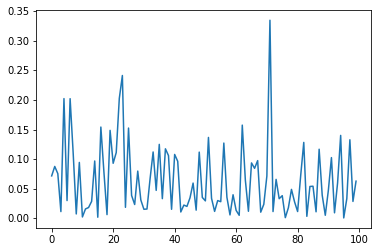

In [92]:
comp = [np.abs(1- (cohs[i] / hols[i])) for i in range(100)]
import matplotlib.pyplot as plt
plt.plot(comp)
plt.show()

In [83]:
max(comp)

0.3346616217649947

In [89]:
cohsd = []
holsd = []
#check 100 random diagonal weight matricies 
for i in range(100):
    

    temp_mat = np.random.random((3))
    #print(np.diag(temp_mat))

    W = np.diag(temp_mat)
    Ws = np.sqrt(W)

    im_bit = Ws@jsin@D@jsin@Ws

    im_bit_abs = 2*(im_bit[0,1]**2+im_bit[0,2]**2+im_bit[2,1]**2)**(0.5)

    cohsd.append(np.trace(W@jsin) + im_bit_abs)
    #os.system("clear")
    holsd.append( naghol_spd(rho,drho,phi,gamma,n,W))
    #print("-------------------------------------")



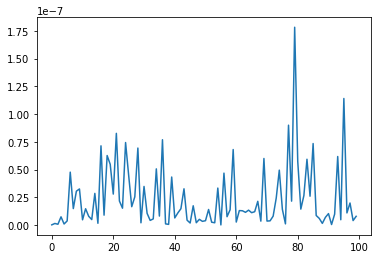

In [93]:
compd = [np.abs(1- (cohsd[i] / holsd[i])) for i in range(100)]
import matplotlib.pyplot as plt
plt.plot(compd)
plt.show()

In [34]:
comp = bloch_comp(n)
comp = comp[1:]
im_list = [1,5,7,8,10,13]
comp_im = [comp[i] for i in im_list]
comp = [comp[i] for i in range(len(comp)) if i not in im_list]

In [94]:

n     = 2
alpha = [0]*3
gamma = 0.0
for i in range(1000):
    phi   = qt.Qobj(qt.rand_ket(4), dims = [[2]*n,[1]*n])
    rand = np.random.choice(len(comp), 2)

    du = [comp[rand[0]],comp[rand[1]],comp_im[np.random.choice(len(comp_im))] ]
    #print(du)

    rho   = phi*phi.dag()
    drho  = [dlambda(rho,h) for h in du]


    L = [2*i for i in drho]

    try:
        jsin = qfim_pure(rho,L)
    except:
        print('singular 1st catch')
        continue
        

    D    = d_mat(rho,L)

    temp_mat = np.random.random((3,3))
    #temp_mat = 0.5*(temp_mat + temp_mat.transpose())
    temp_mat = temp_mat@temp_mat.transpose()
    W = temp_mat
    W = np.eye(3)
    Ws = np.sqrt(W)


    im_bit = Ws@jsin@D@jsin@Ws

    im_bit_abs = 2*(im_bit[0,1]**2+im_bit[0,2]**2+im_bit[2,1]**2)**(0.5)
    #print(jsin, im_bit_abs)
    coh_bound = np.trace(W@jsin) + im_bit_abs

    if coh_bound > 1e8:
        print('singular 2nd catch')
        continue
    print("coh bound: ",coh_bound)

    #os.system("clear")
    hol_bound = naghol_spd(rho,drho,phi,gamma,n,W)
    print("Hol bound :", hol_bound)
    print('rel def: ', abs(1-coh_bound/hol_bound))
    print("-------------------------------------")


singular 1st catch
singular 2nd catch
coh bound:  11.054615781756754
Hol bound : 9.902330236386874
rel def:  0.1163650896165549
-------------------------------------
coh bound:  5.897040490987102
Hol bound : 4.891809308835108
rel def:  0.20549271623005505
-------------------------------------
coh bound:  12.927790283988093
Hol bound : 12.532483713715084
rel def:  0.031542556072935435
-------------------------------------
coh bound:  10.65956666595852
Hol bound : 9.704157112763108
rel def:  0.09845363611630309
-------------------------------------
coh bound:  28.727418480830117
Hol bound : 26.119286471916354
rel def:  0.09985464234323738
-------------------------------------
coh bound:  6.994334049230691
Hol bound : 5.525342003032203
rel def:  0.2658644560630514
-------------------------------------
coh bound:  5.801359592676491
Hol bound : 5.800144596846342
rel def:  0.00020947681732108592
-------------------------------------
coh bound:  7.851873686092196
Hol bound : 6.592106771309311

Hol bound : 5.141188125741059
rel def:  0.06198169528657638
-------------------------------------
coh bound:  6.065793866437683
Hol bound : 5.629709176409765
rel def:  0.07746131751445495
-------------------------------------
singular 1st catch
coh bound:  18.533042978418703
Hol bound : 14.05193505839971
rel def:  0.31889614500747054
-------------------------------------
coh bound:  23.37303905343717
Hol bound : 22.59515313893817
rel def:  0.03442711406803767
-------------------------------------
coh bound:  28.457247679047846
Hol bound : 23.47437177243703
rel def:  0.21226876505643366
-------------------------------------
coh bound:  17.332826430406875
Hol bound : 15.550783814031249
rel def:  0.11459503505975799
-------------------------------------
coh bound:  6.512826912175979
Hol bound : 5.046244700469636
rel def:  0.2906284373347676
-------------------------------------
coh bound:  21.719768497636647
Hol bound : 17.682462950109546
rel def:  0.2283225792084631
---------------------

Hol bound : 3.5178136956774435
rel def:  0.33063087989208495
-------------------------------------
coh bound:  4.58838353607363
Hol bound : 3.7415441475497744
rel def:  0.22633419655850529
-------------------------------------
coh bound:  15.416056306058142
Hol bound : 12.024047735768509
rel def:  0.2821020545518347
-------------------------------------
coh bound:  5.861369327672455
Hol bound : 5.606185552540422
rel def:  0.04551825349704974
-------------------------------------
coh bound:  15.300534640048408
Hol bound : 12.991402518739509
rel def:  0.17774309725051474
-------------------------------------
coh bound:  5.818821717006619
Hol bound : 4.654552912816043
rel def:  0.25013547509253353
-------------------------------------
coh bound:  6.470520172248872
Hol bound : 6.061998045239564
rel def:  0.06739067283766564
-------------------------------------
coh bound:  63.818890764352915
Hol bound : 57.1028606752315
rel def:  0.11761284828300234
-------------------------------------
co

Hol bound : 3.152305356210668
rel def:  0.21548109174804342
-------------------------------------
coh bound:  6.982605352189681
Hol bound : 6.875535034096971
rel def:  0.015572652537108711
-------------------------------------
coh bound:  9.802484081103623
Hol bound : 7.947233684283606
rel def:  0.23344606067000995
-------------------------------------
coh bound:  13.985689538066767
Hol bound : 11.528044671034126
rel def:  0.21318835389385926
-------------------------------------
coh bound:  7.325287254585239
Hol bound : 7.031665378915045
rel def:  0.041757088804401876
-------------------------------------
coh bound:  4.248795875440157
Hol bound : 3.423601546510417
rel def:  0.24103106559548038
-------------------------------------
singular 2nd catch
coh bound:  6.524543360334155
Hol bound : 5.082503856496075
rel def:  0.2837261996358298
-------------------------------------
coh bound:  30.391193371085393
Hol bound : 30.030143443031566
rel def:  0.012022917197806793
-------------------

Hol bound : 5.420411225646663
rel def:  0.2755693292974333
-------------------------------------
coh bound:  19.537156523062414
Hol bound : 15.151880020609855
rel def:  0.28942127950377294
-------------------------------------
coh bound:  8.24726834402722
Hol bound : 8.003335498109637
rel def:  0.030478897951385253
-------------------------------------
coh bound:  11.160730331266523
Hol bound : 8.511306446593462
rel def:  0.311282868417158
-------------------------------------
coh bound:  6.430605246918255
Hol bound : 5.021061270001098
rel def:  0.2807263048827222
-------------------------------------
coh bound:  12.45841963693374
Hol bound : 10.041643091804966
rel def:  0.24067540770305995
-------------------------------------
coh bound:  5.839744654833933
Hol bound : 4.508471059084681
rel def:  0.2952827196409973
-------------------------------------
coh bound:  5.397626890220964
Hol bound : 4.1968052399851254
rel def:  0.2861275616974055
-------------------------------------
coh bou

Hol bound : 9.195014777596688
rel def:  0.2771968510900584
-------------------------------------
coh bound:  7.7796789593365965
Hol bound : 5.9206601255535105
rel def:  0.3139884395254473
-------------------------------------
coh bound:  13.07540224053362
Hol bound : 11.497474234400517
rel def:  0.13724127351483273
-------------------------------------
coh bound:  38.157141027664096
Hol bound : 33.81187059826014
rel def:  0.12851316275969515
-------------------------------------
coh bound:  12.900058121420603
Hol bound : 10.332220614881654
rel def:  0.2485271658679502
-------------------------------------
coh bound:  27.047092581531977
Hol bound : 26.56042387361062
rel def:  0.018323077607390603
-------------------------------------
coh bound:  13.714496168387676
Hol bound : 12.754831592816764
rel def:  0.07523929803286267
-------------------------------------
coh bound:  19.74083292693978
Hol bound : 15.315182397714002
rel def:  0.28897145422743176
------------------------------------

Hol bound : 6.091709404915392
rel def:  0.28694763778911314
-------------------------------------
coh bound:  10.318747696721417
Hol bound : 10.227600620075542
rel def:  0.008911872885118743
-------------------------------------
coh bound:  5.696533529462124
Hol bound : 5.299866227810087
rel def:  0.07484477618899099
-------------------------------------
singular 1st catch
singular 1st catch
singular 1st catch
coh bound:  5.860033266304629
Hol bound : 4.687647497854812
rel def:  0.2501010942026529
-------------------------------------
coh bound:  5.031355860937438
Hol bound : 3.8239227143053296
rel def:  0.3157577275594745
-------------------------------------
coh bound:  7.226077448999557
Hol bound : 7.036943755825396
rel def:  0.02687724951866932
-------------------------------------
coh bound:  49.911291028093494
Hol bound : 45.373930232456004
rel def:  0.09999928973293826
-------------------------------------
coh bound:  6.782416942833148
Hol bound : 5.191431490186561
rel def:  0.3

Hol bound : 22.228260323487582
rel def:  0.11130354413567911
-------------------------------------
coh bound:  848.7878470895595
Hol bound : 848.32008186726
rel def:  0.0005514018025718492
-------------------------------------
coh bound:  6.333331580626366
Hol bound : 5.233121858469049
rel def:  0.21023965271834566
-------------------------------------
coh bound:  4.8116980952109225
Hol bound : 3.823527504862645
rel def:  0.2584447448309324
-------------------------------------
coh bound:  8.085477091133713
Hol bound : 6.0094171400995515
rel def:  0.3454677721040629
-------------------------------------
coh bound:  16.303052775600065
Hol bound : 14.272593018360977
rel def:  0.14226284982882942
-------------------------------------
coh bound:  7.474192540138817
Hol bound : 7.309952277470372
rel def:  0.02246803487002791
-------------------------------------
coh bound:  217.95652323351763
Hol bound : 195.7992195899396
rel def:  0.11316339099809403
-------------------------------------
co

Hol bound : 5.498336477854333
rel def:  0.23042392642460374
-------------------------------------
singular 1st catch
coh bound:  4.330873489757401
Hol bound : 3.9275817837647726
rel def:  0.1026819371807084
-------------------------------------
coh bound:  5.305451401208922
Hol bound : 5.302621771294388
rel def:  0.0005336284646686451
-------------------------------------
coh bound:  7.952676668442236
Hol bound : 6.285167070520779
rel def:  0.26530871482200546
-------------------------------------
coh bound:  8.677618701017577
Hol bound : 6.655674880867045
rel def:  0.3037924562635983
-------------------------------------
coh bound:  15.221444024627196
Hol bound : 13.990358887443357
rel def:  0.08799525066428182
-------------------------------------
singular 1st catch
coh bound:  7.9228786721256395
Hol bound : 6.357698936321088
rel def:  0.24618651362410215
-------------------------------------
coh bound:  8.839656484197235
Hol bound : 6.760815522444638
rel def:  0.3074837576696532
---

Hol bound : 3.939249186198333
rel def:  0.28577609967210416
-------------------------------------
singular 1st catch
coh bound:  6.857319615858492
Hol bound : 5.339882394678286
rel def:  0.2841705320500092
-------------------------------------
coh bound:  6.30498535246465
Hol bound : 4.867166461835265
rel def:  0.2954118996964048
-------------------------------------
coh bound:  9.87089003102533
Hol bound : 8.403029326684726
rel def:  0.17468232553696472
-------------------------------------
coh bound:  5.81099496209511
Hol bound : 4.526291246836592
rel def:  0.28383142957413376
-------------------------------------
coh bound:  7.803730699839923
Hol bound : 7.597681337961439
rel def:  0.027120032114135606
-------------------------------------
coh bound:  13.76055336523681
Hol bound : 11.335483927369179
rel def:  0.21393611895230813
-------------------------------------
coh bound:  5.178173739216064
Hol bound : 4.114527351868685
rel def:  0.2585099809494047
-----------------------------

Hol bound : 5.1927776578098515
rel def:  0.12868754614878797
-------------------------------------
coh bound:  8.500179352910289
Hol bound : 6.267445808149785
rel def:  0.35624297570426533
-------------------------------------
coh bound:  10.311119301169521
Hol bound : 9.453758457832699
rel def:  0.09068994592584234
-------------------------------------
coh bound:  15.721481103591831
Hol bound : 12.014777370216608
rel def:  0.3085120613690071
-------------------------------------
coh bound:  27.12631229562139
Hol bound : 22.365728046981186
rel def:  0.21285174525238681
-------------------------------------
singular 2nd catch
coh bound:  5.635240328707014
Hol bound : 5.632421950018551
rel def:  0.000500384863469705
-------------------------------------
coh bound:  7.540518696310782
Hol bound : 5.797819824395057
rel def:  0.30057830782928097
-------------------------------------
coh bound:  6.6872225662240625
Hol bound : 5.3683710240676215
rel def:  0.24567071393607698
------------------

Hol bound : 5.284501621353876
rel def:  0.0008386392720545199
-------------------------------------
coh bound:  21.18669091452087
Hol bound : 16.846899866369135
rel def:  0.25760175952699194
-------------------------------------
coh bound:  4.56874666290966
Hol bound : 3.5166658771138075
rel def:  0.2991699588643646
-------------------------------------
coh bound:  9.846831116179612
Hol bound : 8.959950119114495
rel def:  0.09898280518025548
-------------------------------------
coh bound:  5.169018798202644
Hol bound : 5.167681360264077
rel def:  0.00025880812792578034
-------------------------------------
coh bound:  6.0289714974185635
Hol bound : 4.930369286145517
rel def:  0.22282351432785186
-------------------------------------
coh bound:  5.1252515801660286
Hol bound : 5.124485670031627
rel def:  0.00014946087933886965
-------------------------------------
coh bound:  5.28004607505054
Hol bound : 5.27956809783922
rel def:  9.053339259246229e-05
----------------------------------

Hol bound : 3.658502980438179
rel def:  0.29784442984700243
-------------------------------------
coh bound:  9.23049482403852
Hol bound : 6.8314021444807125
rel def:  0.35118598331912043
-------------------------------------
coh bound:  5.607969738163208
Hol bound : 5.603874348106953
rel def:  0.0007308140407604746
-------------------------------------
coh bound:  6.734575964962333
Hol bound : 5.5055655569035835
rel def:  0.2232305464999247
-------------------------------------
coh bound:  7.344192082741863
Hol bound : 5.507607558631158
rel def:  0.33346321511824684
-------------------------------------
coh bound:  7.98472467935817
Hol bound : 7.984717538446457
rel def:  8.943223950286239e-07
-------------------------------------
coh bound:  8.327264671629516
Hol bound : 6.895884945902502
rel def:  0.2075701287008178
-------------------------------------
coh bound:  26.17436387078616
Hol bound : 22.00008228387911
rel def:  0.18973936247346757
-------------------------------------
coh 

Hol bound : 15.76854159131534
rel def:  0.0918887576748959
-------------------------------------
coh bound:  4.564374877211237
Hol bound : 3.6079226582009456
rel def:  0.2650977611275116
-------------------------------------
coh bound:  5.237857786392931


KeyboardInterrupt: 